# Predict  aggregate demand for beds

At set times of day, we want to know how many beds will be needed for patients in the ED at that time

For aggregation
- evaluation is done for times of day agreed with users

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [5]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))
sys.path.append(str(USER_ROOT / 'ed-predictor' / 'functions'))


model_file_path = PROJECT_ROOT /'data' / 'ed-predictor' / 'trained-models'
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
media_file_path.mkdir(parents=True, exist_ok=True)



## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [6]:
uclh = False

In [7]:
from load_config import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]


## Load data

In [10]:
import pandas as pd
from load_data_utils import set_file_locations

if uclh:
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

visits = pd.read_csv(visits_csv_path)
yta = pd.read_csv(yta_csv_path)

if visits.index.name != 'snapshot_id':
    visits = visits.set_index('snapshot_id')

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date

In [9]:
visits.sort_values(['snapshot_date', 'prediction_time'], inplace = True)

## Generate aggregate predictions for each time of day

In [17]:
from ed_admissions_helper_functions import prepare_for_inference, get_model_name
PATH_ED = 'HyMind/dissemination/data-raw/ED_visits.csv'
from predict.emergency_demand.from_individual_probs import get_prob_dist

from ed_admissions_helper_functions import prepare_snapshots_dict

prob_dist_dict_all = {}
# Process each time of day
for prediction_time_ in prediction_times[3:4]:

    print("\nProcessing :" + str(prediction_time_))
    
    MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', prediction_time_)

    # prepare data 
    X_test, y_test, model = prepare_for_inference(model_file_path, 'ed_admission', prediction_time = prediction_time_, data_path = full_path, single_snapshot_per_visit = False)
    
    # a check that might be useful
    sum(visits.loc[(visits.training_validation_test == 'test') & (visits.prediction_time == prediction_time_), 'is_admitted']) == sum(y_test)

    # select the horizon dates to include in the probability distribution, with the episode slices associated with them
    snapshots_dict = prepare_snapshots_dict(visits[(visits.training_validation_test == 'test') & (visits.prediction_time == prediction_time_)])
    
    # get probability distribution for this time of day
    prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME] = get_prob_dist(
            snapshots_dict, X_test, y_test, model
        )
    
    # # use model name in the path for saving the prob dist
    # full_path = prob_dist_file_path / MODEL__ED_ADMISSIONS__NAME 
    # full_path = full_path.with_suffix('.pickle')
        
    # with open(full_path, 'wb') as f:  # Note the 'wb' mode for binary writing
    #     pickle.dump(prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME], f)
    
    
    
    
    


Processing :(15, 30)
Calculating probability distributions for 182 horizon dates
This may take a minute or more
Processed 10 horizon dates
Processed 20 horizon dates
Processed 30 horizon dates
Processed 40 horizon dates
Processed 50 horizon dates
Processed 60 horizon dates
Processed 70 horizon dates
Processed 80 horizon dates
Processed 90 horizon dates
Processed 100 horizon dates
Processed 110 horizon dates
Processed 120 horizon dates
Processed 130 horizon dates
Processed 140 horizon dates
Processed 150 horizon dates
Processed 160 horizon dates
Processed 170 horizon dates
Processed 180 horizon dates
Processed 182 horizon dates


## Plot one horizon date as an example

In [ ]:
dt = list(snapshots_dict.keys())[0]
# with open(full_path, 'rb') as f:  # Note the 'wb' mode for binary writing
#     prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME] = pickle.load( f)

from viz.prob_dist_plot import prob_dist_plot

title_ = f'Probability distribution for beds needed in time window for patients in ED at {dt} {MODEL__ED_ADMISSIONS__NAME[-4:]}'
prob_dist_plot(prob_dist_data=prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME][dt]['pred_demand'], title_=title_,  include_titles=True)

## Plot qq plot for each time of day

In [14]:
??qq_plot


Signature: qq_plot(prediction_moments, prob_dist_dict, title_)
Source:   
def qq_plot(prediction_moments, prob_dist_dict, title_):
    """
    Generate a QQ plot comparing observed values with model predictions.

    The function aggregates the predicted and observed distributions, calculates their CDF (Cumulative Distribution Function),
    and plots the observed CDF against the predicted CDF to visualize the accuracy of the predictions.

    Parameters:
    - prediction_moments (list): A list of time points of interest.
    - prob_dist_dict (dict): A nested dictionary containing predicted and actual demands for each time point.
      The structure is {time_point: {'pred_demand': pd.DataFrame of predicted value, 'actual_demand': integer}}.
    - title_ (str): Title for the plot.

    Returns:
    - matplotlib.figure.Figure: A figure object containing the QQ plot.
    """

    # Initialize lists to store CDF and observed data
    cdf_data = []
    observed_data = []

    # Loop through


Processing :(15, 30)
ed_admission_1530


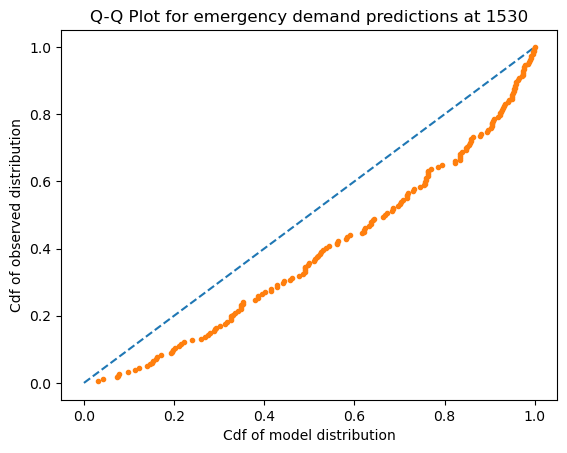

In [18]:
from viz.qq_plot import qq_plot

for prediction_time_ in prediction_times[3:4]:

    print("\nProcessing :" + str(prediction_time_))
    
    # retrieve a name for the model based on the time of day it is trained for
    hour_, min_ = prediction_time_
    min_ = f"{min_}0" if min_ % 60 == 0 else str(min_)
    MODEL__ED_ADMISSIONS__NAME = 'ed_admission_' + f"{hour_:02}" + min_
    print(MODEL__ED_ADMISSIONS__NAME)
    
    title_ = 'Q-Q Plot for emergency demand predictions at ' + f"{hour_:02}" + min_

    plt = qq_plot(snapshots_dict.keys(), prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME], title_)
    
    # use model name in the path for saving the plot
    qq_plot_path = media_file_path / MODEL__ED_ADMISSIONS__NAME 
    qq_plot_path = qq_plot_path.with_suffix('.png')
    
    plt.savefig(qq_plot_path)
        


## Applying a time window

So far, we have created a probability distribution for the number of beds needed at some point, by the set of patients currently in ED. Now consider that we want to predict bed demand within a time window of x hours. 

At the time of prediction, a patient might have just arrived, or might have already been in the ED for some hours. Their probability of being admitted within x hours is different depending how long they have been in the department already. 

In [ ]:
from ed_admissions_helper_functions import prepare_for_inference, get_model_name
PATH_ED = 'HyMind/dissemination/data-raw/ED_visits.csv'
from predict.emergency_demand.from_individual_probs import get_prob_dist

from ed_admissions_helper_functions import prepare_snapshots_dict
from predict.emergency_demand.admission_in_time_window_using_aspirational_curve import create_curve, calculate_probability


prob_dist_dict_all_in_window = {}
# Process each time of day
for prediction_time_ in prediction_times:

    print("\nProcessing :" + str(prediction_time_))
    
    MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', prediction_time_)

    # prepare data 
    X_test, y_test, model = prepare_for_inference(model_file_path, 'ed_admission', prediction_time = prediction_time_, data_path = PATH_ED, single_snapshot_per_visit = False)
    
    # a check that might be useful
    sum(visits.loc[(visits.training_validation_test == 'test') & (visits.prediction_time == prediction_time_), 'is_admitted']) == sum(y_test)
    
    X_test_admission_in_window_prob = X_test[['elapsed_los']].copy()

    time_window_hrs = config['time_window']/60
    X_test_admission_in_window_prob['elapsed_los_hrs'] = X_test_admission_in_window_prob['elapsed_los']/3600

    # get probability of admission within time window
    weights = X_test_admission_in_window_prob.apply(lambda row: calculate_probability(row['elapsed_los_hrs'], time_window_hrs, x1 = 4, y1 = 0.76, x2 = 12, y2 = .99), axis=1)

    # select the horizon dates to include in the probability distribution, with the episode slices associated with them
    snapshots_dict = prepare_snapshots_dict(visits[(visits.training_validation_test == 'test') & (visits.prediction_time == prediction_time_)])
    
    # get probability distribution for this time of day
    prob_dist_dict_all_in_window[MODEL__ED_ADMISSIONS__NAME] = get_prob_dist(
            snapshots_dict, X_test, y_test, model, weights = weights
        )
    
    # use model name in the path for saving the prob dist
    full_path = prob_dist_file_path / str(MODEL__ED_ADMISSIONS__NAME + '_in_time_window')
    full_path = full_path.with_suffix('.pickle')
        
    with open(full_path, 'wb') as f:  # Note the 'wb' mode for binary writing
        pickle.dump(prob_dist_dict_all_in_window[MODEL__ED_ADMISSIONS__NAME], f)
    
    
    

## Compare one horizon date with and without admission in time window

In [ ]:
full_path

In [ ]:
dt = list(snapshots_dict.keys())[0]
with open('/data/hymind/home/zella/HyMind/dissemination/model-output/probability-distributions/ed_admission_2200.pickle', 'rb') as f:  # Note the 'wb' mode for binary writing
    prob_dict = pickle.load( f)
    
with open('/data/hymind/home/zella/HyMind/dissemination/model-output/probability-distributions/ed_admission_2200_in_time_window.pickle', 'rb') as f:  # Note the 'wb' mode for binary writing
    prob_dict_in_window = pickle.load( f)

from viz.prob_dist_plot import prob_dist_plot

prediction_time_ = prediction_times[-1]
MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', prediction_time_)

title_ = f'Probability distribution for beds needed for patients in ED at {dt} {MODEL__ED_ADMISSIONS__NAME[-4:]}'
prob_dist_plot(prob_dict[dt]['pred_demand'], title_=title_,  include_titles=True)

title_ = f'Probability distribution for beds needed in time window for patients in ED at {dt} {MODEL__ED_ADMISSIONS__NAME[-4:]}'
prob_dist_plot(prob_dict_in_window[dt]['pred_demand'], title_=title_,  include_titles=True)

In [ ]:
weights